<a href="https://colab.research.google.com/github/snigdhasaha7/diffusion-for-photoacoustic/blob/main/CS101TrainingSelfImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Snigdha Saha's code notebook for Week 3 testing/trials

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class GaussianFourierProjection(nn.Module): 
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [2]:
import functools 

device = 'cuda'

def marginal_prob_std(t,sigma):
    t = torch.tensor(t, device=device)
    std = torch.sqrt((sigma**(2 * t) - 1.) / (2. * np.log(sigma)))
    return std 

def diffusion_coeff(t, sigma): 
    return torch.tensor(sigma**t, device=device)

In [3]:
sigma=25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

Variance Exploding SDE implementation: 

In [5]:
def ve_marginal_prob_std(t,sigma_min,sigma_max):
    std = sigma_min * (sigma_max / sigma_min) ** t
    return std

def ve_diffusion_coeff(t,sigma_min,sigma_max): 
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min)),
                                                device=t.device))
    return diffusion

sigma_min = 0.01
sigma_max = 25
ve_marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
ve_diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)

sub Variance Preserving SDE

In [6]:
def subvp_marginal_prob_std(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    std = 1 - torch.exp(2. * log_mean_coeff)
    return std

def subvp_diffusion_coeff(t, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    discount = 1. - torch.exp(-2 * beta_min * t - (beta_max - beta_min) * t ** 2)
    diffusion = torch.sqrt(beta_t * discount)
    return diffusion

def subvp_drift_coeff(t, x, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    if beta_t.dim() == 0:
        drift = -0.5 * beta_t * x
    else:
        drift = -0.5 * beta_t[:, None, None, None] * x
    return drift

beta_min = 0.01
beta_max = 5
subvp_marginal_prob_std_fn = functools.partial(subvp_marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
subvp_diffusion_coeff_fn = functools.partial(subvp_diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
subvp_drift_coeff_fn = functools.partial(subvp_drift_coeff, beta_min=beta_min, beta_max=beta_max)

In [7]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
example = next(iter(data_loader))[0][0]

In [9]:
def add_noise(x, marginal_prob_std, eps=1e-5,rand=True, t=None): 
    if rand:
        random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
       # print(random_t.shape)
        std = marginal_prob_std(random_t)
    else:
        t_tensor = torch.tensor([t], device=x.device) 
       # print(t_tensor.shape)
        std = marginal_prob_std(t_tensor)
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None, None, None]
    return perturbed_x 

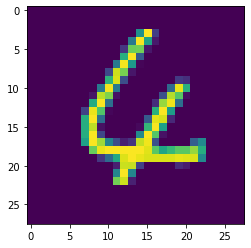

In [10]:
plt.imshow(torch.squeeze(example))

noising with original sigma^t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


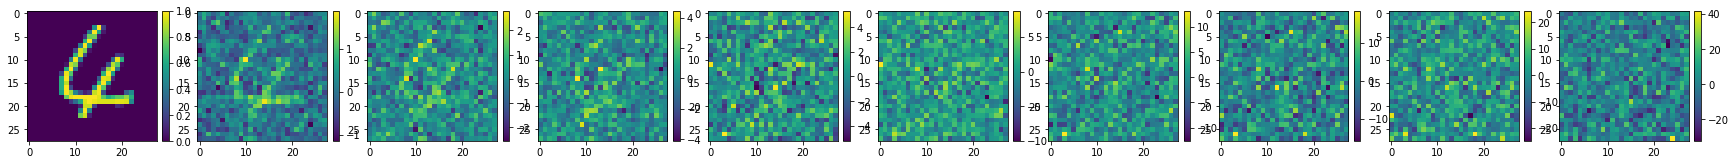

In [11]:
x = example.to(device)
fig, axs = plt.subplots(1, 10)
fig.tight_layout(pad=10)
fig.set_figheight(30)
fig.set_figwidth(30)
img = axs[0].imshow(torch.squeeze(x.cpu()))
plt.colorbar(img, ax=axs[0],fraction=0.046, pad=0.04)

for i in range(1,10):
    perturbed_x = torch.squeeze(add_noise(x, marginal_prob_std_fn, rand=False, t=i*0.1))
    img = axs[i].imshow(perturbed_x.cpu())
    x = torch.unsqueeze(perturbed_x,dim=0)
    plt.colorbar(img,ax=axs[i],fraction=0.046, pad=0.04)

noising with VE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


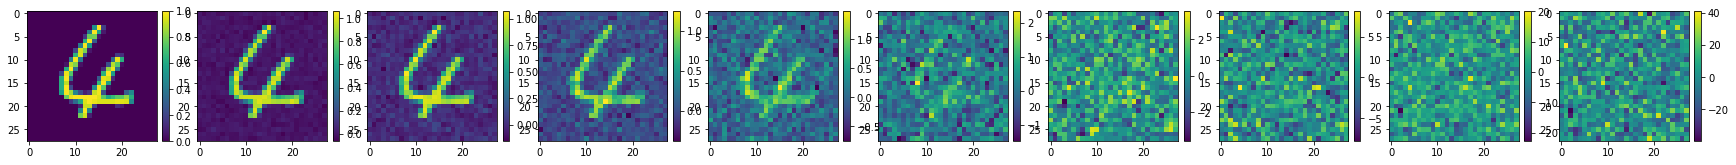

In [12]:
x = example.to(device)
fig, axs = plt.subplots(1, 10)
fig.tight_layout(pad=10)
fig.set_figheight(30)
fig.set_figwidth(30)
img = axs[0].imshow(torch.squeeze(x).cpu())
plt.colorbar(img, ax=axs[0],fraction=0.046, pad=0.04)

for i in range(1,10):
    perturbed_x = torch.squeeze(add_noise(x, ve_marginal_prob_std_fn, rand=False, t=i*0.1))
    img = axs[i].imshow(perturbed_x.cpu())
    x = torch.unsqueeze(perturbed_x,dim=0)
    plt.colorbar(img,ax=axs[i],fraction=0.046, pad=0.04)

noising with subVP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  This is separate from the ipykernel package so we can avoid doing imports until


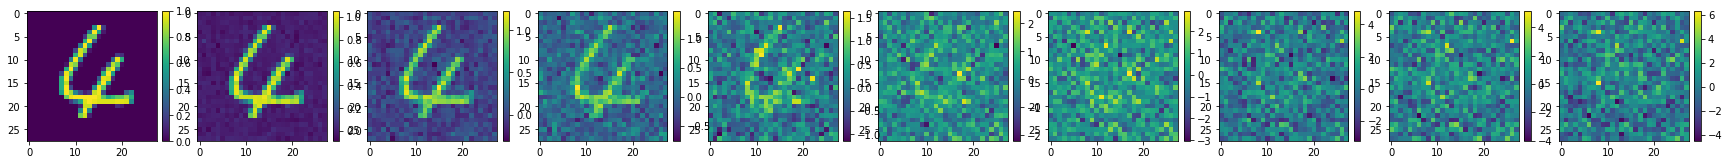

In [13]:
x = example.to(device)
fig, axs = plt.subplots(1, 10)
fig.tight_layout(pad=10)
fig.set_figheight(30)
fig.set_figwidth(30)
img = axs[0].imshow(torch.squeeze(x).cpu())
plt.colorbar(img, ax=axs[0],fraction=0.046, pad=0.04)

for i in range(1,10):
    perturbed_x = torch.squeeze(add_noise(x, subvp_marginal_prob_std_fn, rand=False, t=i*0.1))
    img = axs[i].imshow(perturbed_x.cpu())
    x = torch.unsqueeze(perturbed_x,dim=0)
    plt.colorbar(img,ax=axs[i],fraction=0.046, pad=0.04)

training with ve

In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model_ve = torch.nn.DataParallel(ScoreNet(marginal_prob_std=ve_marginal_prob_std_fn))
score_model_ve = score_model_ve.to(device)

n_epochs =  50
## size of a mini-batch
batch_size =  32
## learning rate
lr=1e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model_ve.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model_ve, x, ve_marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model_ve.state_dict(), 'ckpt_ve.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

training with subvp

In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model_subvp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=subvp_marginal_prob_std_fn))
score_model_subvp = score_model_subvp.to(device)

n_epochs =  50
## size of a mini-batch
batch_size =  32
## learning rate
lr=1e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model_subvp.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model_subvp, x, subvp_marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0] 
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model_subvp.state_dict(), 'ckpt_subvp.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50
## size of a mini-batch
batch_size =  32
## learning rate
lr=1e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           drift_coeff = None,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      if drift_coeff == None:
          mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      else:
          f = drift_coeff(batch_time_step, x)
          mean_x = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               drift_coeff=None,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      if drift_coeff == None:
          x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      else:
          f = drift_coeff(batch_time_step, x)
          x_mean = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                drift_coeff=None,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    f = drift_coeff(torch.tensor(t), x).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps) + f
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


Number of function evaluations: 254


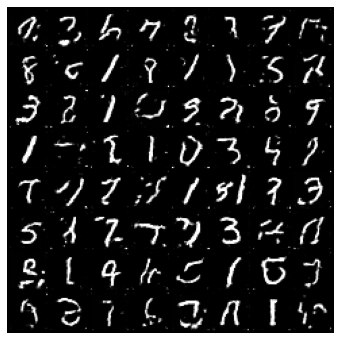

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
model_pth = 'ckpt_subvp.pth' #@param ['ckpt.pth', 'ckpt_ve.pth', 'ckpt_subvp.pth'] {'type': 'string'}
ckpt = torch.load(model_pth, map_location=device)
score_model_subvp.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model_subvp, 
                  subvp_marginal_prob_std_fn,
                  subvp_diffusion_coeff_fn, 
                  subvp_drift_coeff_fn,
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


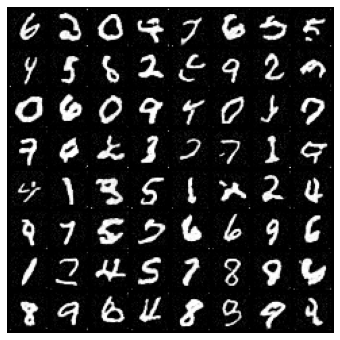

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
model_pth = 'ckpt.pth' #@param ['ckpt.pth', 'ckpt_ve.pth'] {'type': 'string'}
ckpt = torch.load(model_pth, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

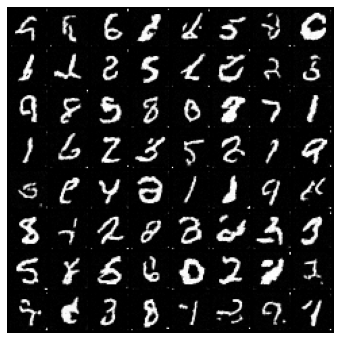

In [ ]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
model_pth = 'ckpt_ve.pth' #@param ['ckpt.pth', 'ckpt_ve.pth'] {'type': 'string'}
ckpt = torch.load(model_pth, map_location=device)
score_model_ve.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model_ve, 
                  ve_marginal_prob_std_fn,
                  ve_diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()